In [1]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tqdm
import os
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller,acf,pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from pandas import Series
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA,KernelPCA
from xgboost import XGBRFRegressor
from xgboost import plot_importance
import sys
import gc
import pickle
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [62]:
sales=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/sales_train.csv'))
shops=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/shops.csv'))
test=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/test.csv'))
item_cat=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/item_categories.csv'))
item=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/items.csv'))

In [8]:
sales['date']=sales.date.apply(lambda x: pd.to_datetime(x))
monthly_sales=sales.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].agg({'date':['min','max'],'item_price':'mean','item_cnt_day':'sum'})

Text(0.5, 1.0, 'Top10 Item Cat by Count')

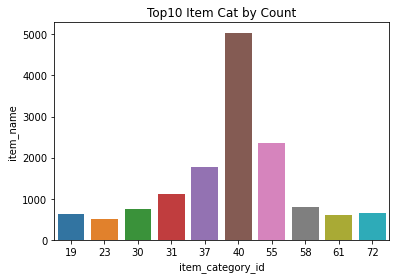

In [26]:
top10_items=item.groupby(['item_category_id']).count().sort_values(by=['item_name'],ascending=False).iloc[:10]
sns.barplot(top10_items.index,top10_items.item_name).set_title('Top10 Item Cat by Count')

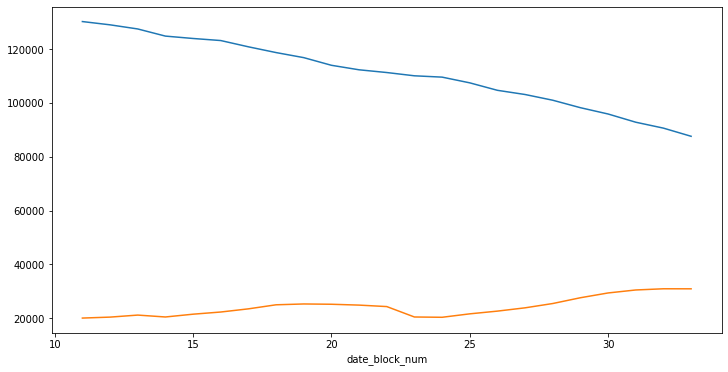

In [27]:
## Mean of accumulated sum to identify trends
ts=sales.groupby('date_block_num')['item_cnt_day'].sum()
plt.figure(figsize=(12,6))
ts.rolling(window=12,center=False).mean().plot()
ts.rolling(window=12,center=False).std().plot()

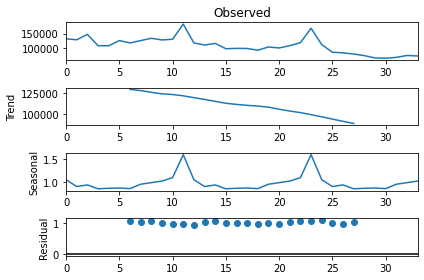

In [87]:
# 'multiplicative model'
sm.tsa.seasonal_decompose(ts.values,freq=12,model='multiplicative').plot()
plt.show()

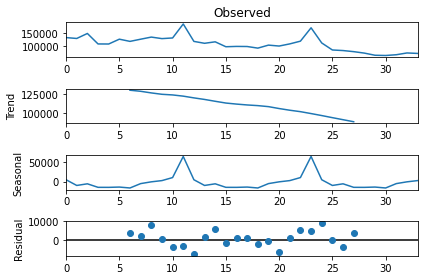

In [28]:
# 'Additive model'
sm.tsa.seasonal_decompose(ts.values,freq=12,model='additive').plot()
plt.show()

In [19]:
## Stationarity tests
def test_stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    dtest=adfuller(ts,autolag='AIC')
    dfoutput=pd.Series(dtest[:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dtest[4].items():
        dfoutput['Critical Value {}'.format(key)]=value
    print(dfoutput)

In [50]:
## P_value >5%
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value 1%              -3.646135
Critical Value 5%              -2.954127
Critical Value 10%             -2.615968
dtype: float64


In [29]:
def difference(df,interval=1):
    diff=[]
    for i in range(interval,len(df)):
        value=df[i]-df[i-interval]
        diff.append(value)
    return pd.Series(diff)
def inverse_diff(last_ob,value):
    return value+last_ob

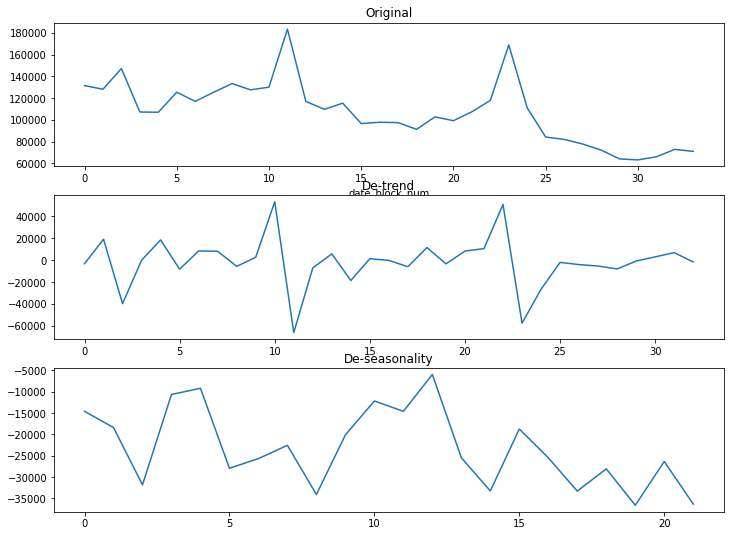

In [30]:
new_ts=difference(ts)
new_12_ts=difference(ts,12)
plt.figure(figsize=(12,9))
plt.subplot(311)
ts.plot(title='Original')
plt.subplot(312)
new_ts.plot(title='De-trend')
plt.subplot(313)
new_12_ts.plot(title='De-seasonality')

In [61]:
## p-value <5% now stationarity of the ts
test_stationarity(new_12_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value 1%              -3.788386
Critical Value 5%              -3.013098
Critical Value 10%             -2.646397
dtype: float64


## AR,MA and ARMA Models

In [4]:
def tsplot(y,lags=None,figsize=(10,8),style='bmh',title=''):
    if not isinstance(y,pd.Series):
        y=pd.Series(y)
    with plt.style.context(style):
        fig=plt.figure(figsize=figsize)
        layout=(3,2)
        ts_ax=plt.subplot2grid(layout,(0,0),colspan=2)
        acf_ax=plt.subplot2grid(layout,(1,0))
        pacf_ax=plt.subplot2grid(layout,(1,1))
        qq_ax=plt.subplot2grid(layout,(2,0))
        pp_ax=plt.subplot2grid(layout,(2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y,lags=lags,ax=acf_ax,alpha=0.5)
        smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax,alpha=0.5)
        sm.qqplot(y,line='s',ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y,sparams=(y.mean(),y.std()),plot=pp_ax)
        
        plt.tight_layout()
    return 

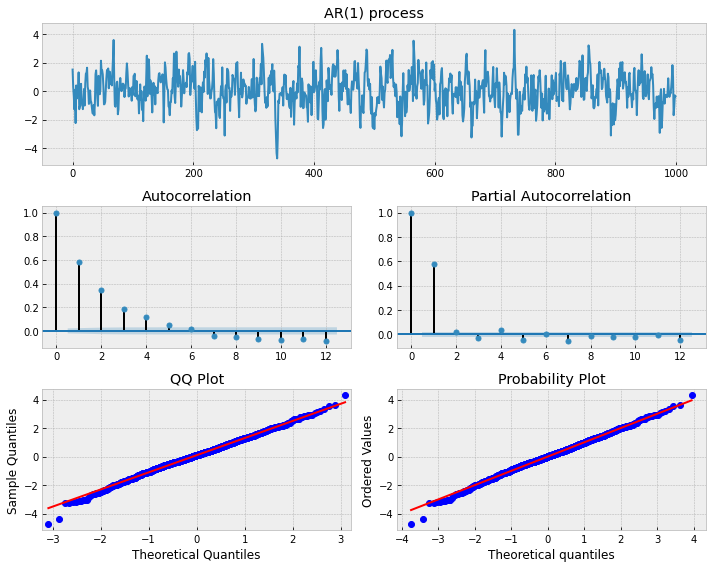

In [85]:
np.random.seed(1)
n_sampels=1000
a=0.6
x=w=np.random.normal(size=1000)
for t in range(n_sampels):
    x[t]=a*x[t-1]+w[t]
limit=12
_=tsplot(x,lags=limit,title='AR(1) process')

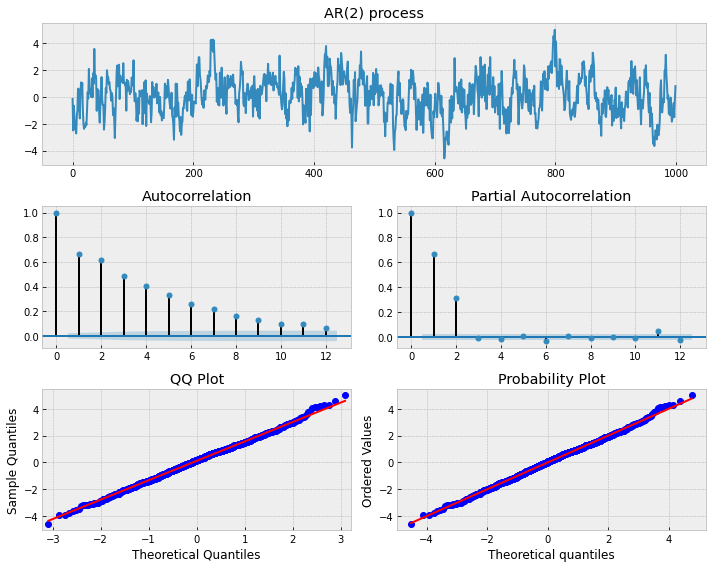

In [100]:
n=1000
alphas=np.array([.444,.333])
betas=np.array([0.])
ar=np.r_[1,-alphas]
ma=np.r_[1,betas]
ar2=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n)
_=tsplot(ar2,lags=12,title='AR(2) process')

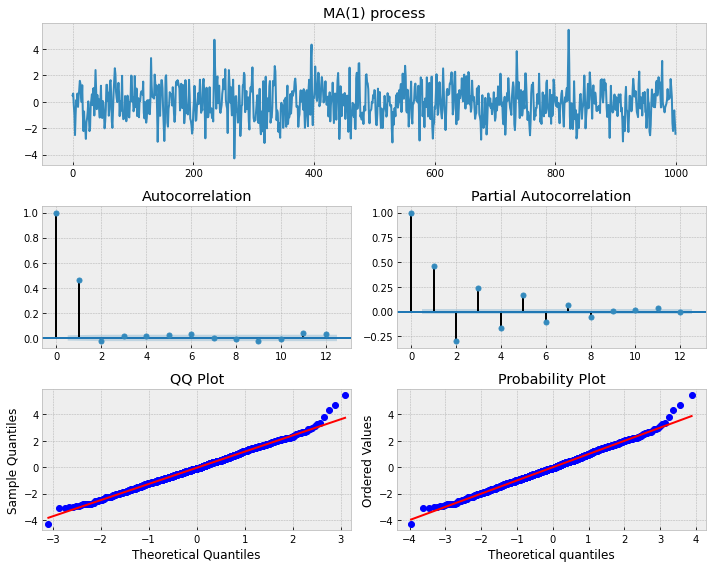

In [101]:
n=1000
alphas=np.array([0.])
betas=np.array([0.8])
ar=np.r_[1,-alphas]
ma=np.r_[1,betas]
ma1=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n)
_=tsplot(ma1,lags=12,title='MA(1) process')

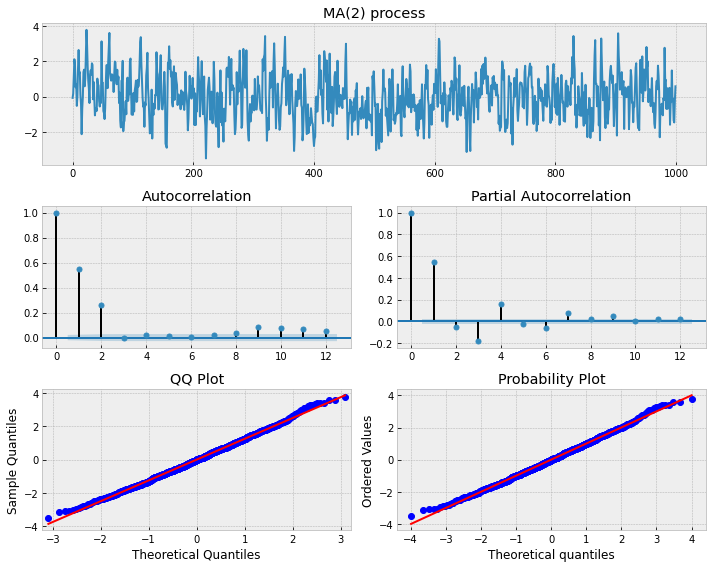

In [102]:
n=1000
alpahs=np.array([0.])
betas=np.array([0.6,0.4])
ar=np.r_[1,-alpahs]
ma=np.r_[1,betas]
ma2=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n)
_=tsplot(ma2,lags=12,title='MA(2) process')

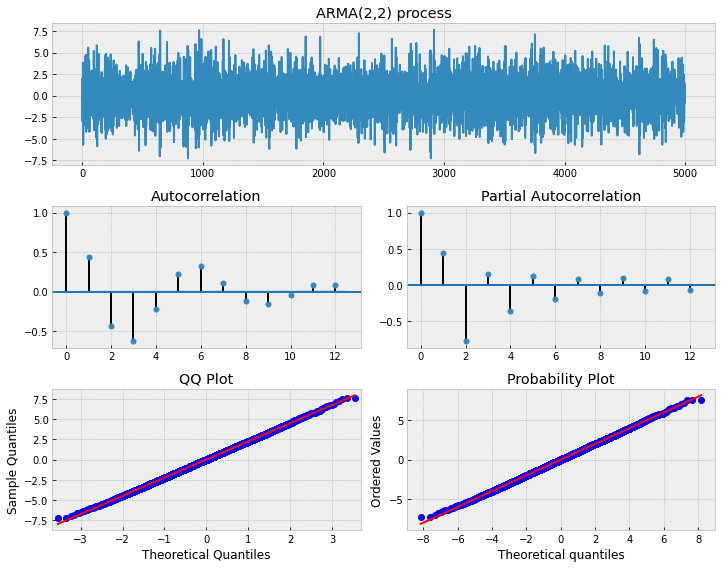

In [30]:
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

In [35]:
## Best Model: ARMA(1,1)
best_aic=np.inf
best_order=None
best_mdl=None
for i in range(5):
    for j in range(5):
        try:
            tmp_mdl=smt.ARMA(new_12_ts.values,order=(i,j)).fit(method='mle',trend='nc')
            tmp_aic=tmp_mdl.aic
            if tmp_aic<best_aic:
                best_aic=tmp_aic
                best_order=(i,j)
                best_mdl=tmp_mdl
        except:
            continue
print('aic:{:6.5f} |order:{}'.format(best_aic,best_order))

aic:472.99703 |order:(1, 1)


In [31]:
## Insert date index
ts.index=pd.date_range(start='2013-01-01',end='2015-10-01',freq='MS')
ts=ts.reset_index()

## Prophet

In [34]:
ts.columns=['ds','y']

In [36]:
model=Prophet(yearly_seasonality=True)## instantiate Prophet with yearly seasonality as the data is monthly
model.fit(ts)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
future=model.make_future_dataframe(periods=5,freq='MS')
forecast=model.predict(future)

In [40]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957161,79865.002634,86173.703852
35,2015-12-01,125513.062787,121977.434895,128547.450090
36,2016-01-01,75625.688443,72629.893949,78947.755796
37,2016-02-01,40109.144323,36913.430598,43468.539980
38,2016-03-01,76664.084516,73686.830535,79709.415331


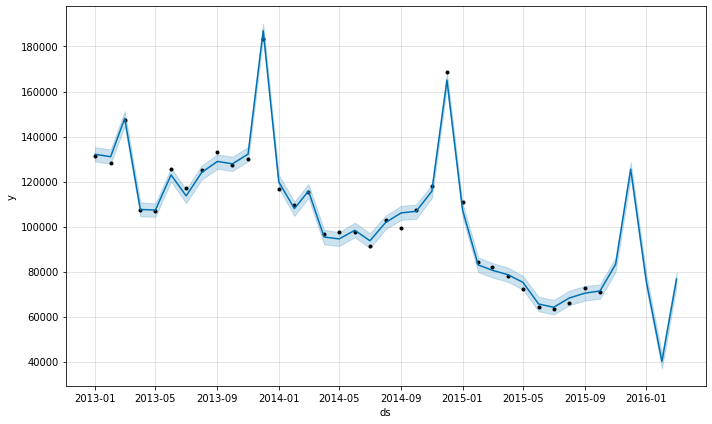

In [43]:
model.plot(forecast)
plt.show()

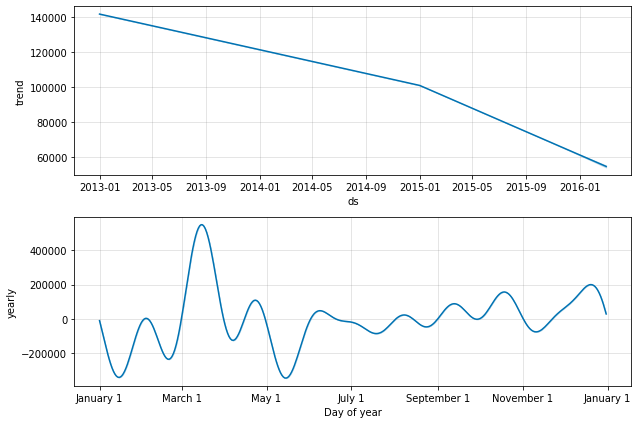

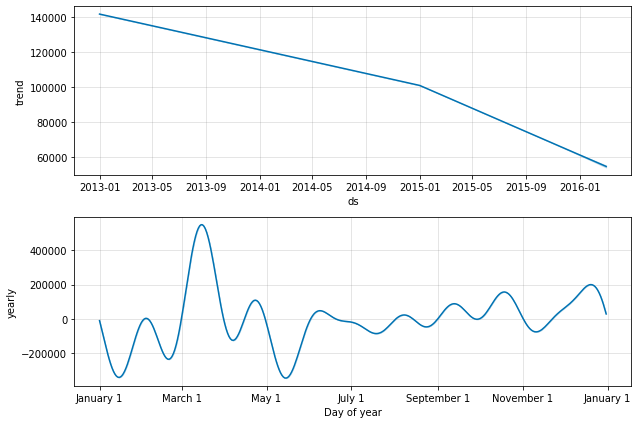

In [44]:
model.plot_components(forecast)

## Hierarchical Time Series

In [47]:
total_sales=sales.groupby(['date_block_num'])['item_cnt_day'].sum()
dates=pd.date_range(start='2013-01-01',end='2015-10-01',freq='MS')
total_sales.index=dates

In [52]:
monthly_sales=sales.groupby(['shop_id','item_id','date_block_num'])["item_cnt_day"].sum()

In [58]:
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)
monthly_sales=monthly_sales.T

In [65]:
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()

In [67]:
import time
start_time=time.time()

In [82]:
forecastsDict = {}
for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]],keys=['ds','y'], axis = 1)
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    if (node== 10):
        end_time=time.time()
        print("forecasting for ",node,"th node and took",end_time-start_time,"s")
        break


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

forecasting for  10 th node and took 1238.6163787841797 s


In [85]:
monthly_shop_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
monthly_shop_sales=monthly_shop_sales.unstack(level=-1)
monthly_shop_sales.fillna(0,inplace=True)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()

### Middle Out-predict store level

In [92]:
start_time=time.time()
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], 
    monthly_shop_sales.iloc[:, node+1]],keys=['ds','y'], axis = 1)
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [109]:
nCols=len(list(forecastsDict.keys()))
for key in range(0,nCols):
    f1=np.array(forecastsDict[key].yhat)
    f2=f1[:,np.newaxis]
    if key==0:
        predictions=f2.copy()
    else:
        predictions=np.concatenate((predictions,f2),axis=1)

In [123]:
predictions_unknown=predictions[-1]

## XGBoost

In [63]:
def plot_features(booster,figsize):
    f,ax=plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster,ax=ax)

In [ ]:
## sales,shops,test,item_cat,item

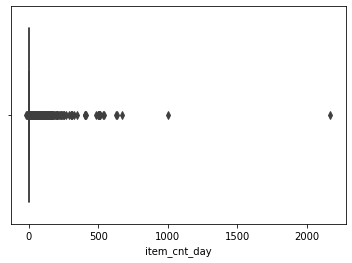

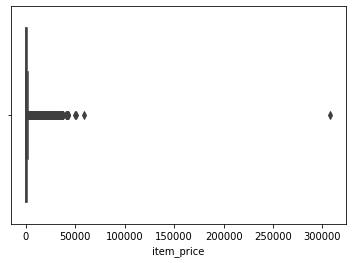

In [130]:
## Identify outliers 
sns.boxplot(sales.item_cnt_day)
plt.show()
sns.boxplot(sales.item_price)

In [64]:
## Drop outliers
sales.drop(sales[sales.item_cnt_day>1000].index,axis=0,inplace=True)
sales.drop(sales[sales.item_price>250000].index,axis=0,inplace=True)
sales.loc[sales.item_price<0,'item_price']=sales[(sales.shop_id==32)&(sales.item_id==2973)&(sales.date_block_num==4)&(sales.item_price>0)]['item_price'].median()

In [65]:
## Delete duplicates of shop_id
sales.loc[sales.shop_id==0,'shop_id']=57
test.loc[test.shop_id==0,'shop_id']==57
sales.loc[sales.shop_id==1,'shop_id']=58
test.loc[test.shop_id==1,'shop_id']=58
sales.loc[sales.shop_id==10,'shop_id']=11
test.loc[test.shop_id==10,'shop_id']=11

In [66]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city']=[c[0] for c in shops.shop_name.str.split(' ')]
shops.loc[shops.city=='!Якутск','city']='Якутск'
le=LabelEncoder()
shops['city_code']=le.fit_transform(shops.city)
shops=shops[['shop_id','city_code']]
item_cat['type']=item_cat.item_category_name.str.split('-').map(lambda x:x[0].strip())
item_cat['type_code']=le.fit_transform(item_cat.type)
item_cat['subtype']=item_cat.item_category_name.str.split('-').map(lambda x:x[1] if len(x)>1 else x[0])
item_cat['subtype_code']=le.fit_transform(item_cat.subtype)
item_cat=item_cat[['item_category_id','type_code', 'subtype_code']]
item.drop(['item_name'],axis=1,inplace=True)

In [67]:
len(set(test.item_id)-set(test.item_id).intersection(set(sales.item_id))),len(set(test.item_id))

(363, 5100)

In [68]:
matrix=[]
cols=['date_block_num','shop_id','item_id']
## Use product to created nested for loop
for i in range(34):
    sales_train=sales[sales.date_block_num==i]
    matrix.append(np.array(list(product([i],sales_train.shop_id.unique(),sales_train.item_id.unique())),dtype='int16'))

matrix=pd.DataFrame(np.vstack(matrix),columns=cols)


In [69]:
matrix['date_block_num']=matrix.date_block_num.astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
sales['revenue']=sales.item_cnt_day*sales.item_price

In [70]:
group=sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':['sum']})
group.columns=['item_cnt_month']
group=group.reset_index()
matrix=matrix.merge(group,on=cols,how='left')
matrix['item_cnt_month']=matrix.item_cnt_month.fillna(0).clip(0,20).astype(np.float16)

In [72]:
test['date_block_num']=34
test['date_block_num']=test.date_block_num.astype(np.int8)
test['shop_id']=test.shop_id.astype(np.int8)
test['item_id']=test.item_id.astype(np.int16)
matrix=pd.concat([matrix,test],ignore_index=True,sort=False,keys=cols)
matrix.fillna(0,inplace=True)
matrix=matrix.merge(shops,on=['shop_id'],how='left')
matrix=matrix.merge(item,on=['item_id'],how='left')
matrix=matrix.merge(item_cat,on=['item_category_id'],how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [73]:
## Create time lag
def lag_feature(df,lags,col):
    tmp=df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted=tmp.copy()
        shifted.columns=['date_block_num','shop_id','item_id',col+'_lag_'+str(i)]
        shifted['date_block_num']+=i
        df=df.merge(shifted,on=['date_block_num','shop_id','item_id'],how='left')
    return df 

In [74]:
matrix=lag_feature(matrix,[1,2,3,6,12], 'item_cnt_month')

In [75]:
group=matrix.groupby(['date_block_num']).agg({'item_cnt_month':'mean'})
group.columns=['date_avg_item_cnt']
group.reset_index(inplace=True)
matrix=matrix.merge(group,on=['date_block_num'],how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1],'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'],axis=1,inplace=True)
group=matrix.groupby(['date_block_num','item_id']).agg({'item_cnt_month':'mean'})
group.columns=['date_item_avg_item_cnt']
group.reset_index(inplace=True)
matrix=matrix.merge(group,on=['date_block_num','item_id'],how='left')
matrix['date_item_avg_item_cnt']=matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1,2,3,6,12],'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'],axis=1,inplace=True)
group=matrix.groupby(['date_block_num','shop_id']).agg({'item_cnt_month':'mean'})
group.columns=['date_shop_avg_item_cnt']
group.reset_index(inplace=True)
matrix=matrix.merge(group,on=['date_block_num','shop_id'],how='left')
matrix['date_shop_avg_item_cnt']=matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'],axis=1,inplace=True)
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [76]:
## Price trend
group=sales.groupby(['item_id']).agg({'item_price':'mean'})
group.columns=['item_avg_item_price']
group.reset_index(inplace=True)
matrix=matrix.merge(group,on=['item_id'],how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

In [77]:
group=sales.groupby(['date_block_num','item_id']).agg({'item_price':'mean'})
group.columns=['date_item_avg_item_price']
group.reset_index(inplace=True)
matrix=matrix.merge(group,on=['date_block_num','item_id'],how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [78]:
lags = [1,2,3,4,5,6]
matrix=lag_feature(matrix,lags,'date_item_avg_item_price')
for i in lags:
    matrix['delta_price_lag_'+str(i)]=(matrix['date_item_avg_item_price_lag_'+str(i)]-matrix['item_avg_item_price'])/matrix['item_avg_item_price']

In [79]:
## Combine columns into one columns
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
        else:
            return 0

matrix['delta_price_lag']=matrix.apply(select_trend,axis=1)

In [80]:
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)
features_to_drop =['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    features_to_drop+=['date_item_avg_item_price_lag_'+str(i)]
    features_to_drop+=['delta_price_lag_'+str(i)]
matrix.drop(features_to_drop,axis=1,inplace=True)

In [81]:
group=sales.groupby(['date_block_num','shop_id']).agg({'revenue':'sum'})
group.columns=['date_shop_revenue']
group.reset_index(inplace=True)
matrix=matrix.merge(group,on=['date_block_num','shop_id'],how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)
group=group.groupby(['shop_id']).agg({'date_shop_revenue':'mean'})
group.columns=['shop_avg_revenue']
group.reset_index(inplace=True)
matrix=matrix.merge(group,on=['shop_id'],how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)
matrix['delta_revenue']=(matrix['date_shop_revenue']-matrix['shop_avg_revenue'])/matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)
matrix=lag_feature(matrix,[1],'delta_revenue')
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [82]:
## Month calculation N % 12
matrix['month']=matrix['date_block_num']%12
days=pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days']=matrix['month'].map(days).astype(np.int8)

In [83]:
cache={}
matrix['item_shop_last_sale']=-1
matrix['item_shop_last_sale']=matrix['item_shop_last_sale'].astype(np.int8)
for idx,row in matrix.iterrows():
    key=str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key]=row.date_block_num
    else:
        matrix.at[idx,'item_shop_last_sale']=row.date_block_num-cache[key]
        cache[key]=row.date_block_num

In [84]:
cache={}
matrix['item_last_sale']=-1
matrix['item_last_sale']=matrix['item_last_sale'].astype(np.int8)
for idx,row in matrix.iterrows():
    key=row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        if row.date_block_num>cache[key]:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - cache[key]
            cache[key] = row.date_block_num  

In [85]:
matrix['item_shop_first_sale']=matrix.date_block_num-matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale']=matrix.date_block_num-matrix.groupby(['item_id'])['date_block_num'].transform('min')

In [97]:
matrix=matrix[matrix.date_block_num>11]

In [112]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col)&(df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0,inplace=True)
    return df 
matrix=fill_na(matrix)

In [119]:
matrix.to_pickle('data.pkl')

In [2]:
data=pd.read_pickle('data.pkl')

In [3]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [4]:
X_train=data[data.date_block_num<33].drop(['item_cnt_month'],axis=1)
y_train=data[data.date_block_num<33]['item_cnt_month']
X_valid=data[data.date_block_num==33].drop(['item_cnt_month'],axis=1)
y_valid=data[data.date_block_num==33]['item_cnt_month']
X_test=data[data.date_block_num==34].drop(['item_cnt_month'],axis=1)

In [5]:
xgb=XGBRFRegressor(max_depth=8,n_estimators=1000,min_child_weight=0.8,colsample_bytree=0.8,subsample=0.8,eta=0.3,seed=42)

In [ ]:
xgb.fit(X_train,y_train,eval_metric='rmse',eval_set=[(X_train,y_train),(X_valid,y_valid)],verbose=True,early_stopping_rounds=10)